# Amazon Fine Food Review- Using SVM

In [1]:
# imported necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
#from sklearn.model_selection import cross_val_score
#from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import model_selection
import scipy
import warnings
import seaborn as sns
#from sklearn import cross_validation
from scipy.stats import uniform

In [2]:
# To ignore warnigs
warnings.filterwarnings("ignore")

In [3]:
# connection to sqlite database file
import sqlite3
con = sqlite3.connect("finalassignment.sqlite")

In [4]:
# look at into database table 
pd.read_sql_query("SELECT * FROM sqlite_master WHERE type='table'", con)

,type,name,tbl_name,rootpage,sql
0,table,Reviews,Reviews,2,"CREATE TABLE ""Reviews"" (\n""index"" INTEGER,\n ..."


In [5]:
# read data from table
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [6]:
# Shape of retrived data
cleaned_data.shape

(364171, 12)

In [7]:
# Sort data based on time
cleaned_data["Time"] = pd.to_datetime(cleaned_data["Time"], unit = "s")
cleaned_data = cleaned_data.sort_values(by = "Time")

In [8]:
# To check for class count 
cleaned_data["Score"].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [9]:
# Selecting top 100k data-points
final_100k = cleaned_data.iloc[:10000,:]

In [10]:
# number of class-points in each class
final_100k["Score"].value_counts()

positive    8868
negative    1132
Name: Score, dtype: int64

In [11]:
# converting scores in 0 and 1
final_100k["Score"] = final_100k["Score"].map(lambda x: 1 if x == "positive" else 0)

In [12]:
# Grid search using linear svc to choose best c
# linear svc utillity function
def svc_grid_linear(X_train, y_train):
    C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
    tuned_parameters_grid = dict(alpha = C)
    cv = TimeSeriesSplit(n_splits = 3)
    model_svc_grid = GridSearchCV(SGDClassifier(loss = "hinge", class_weight = "balanced"), param_grid = tuned_parameters_grid, cv = cv, scoring = "roc_auc")
    model_svc_grid.fit(X_train, y_train)
    #calibrate = CalibratedClassifierCV(model_svc_grid, cv = "prefit")
    #model_svc_grid_cal = calibrate.fit(X_train, y_train)
    #scores_grid = cross_val_score(model_lr_grid, X_train, y_train, cv = 10, scoring = 'accuracy')
    print("\n**********GridSearchCV**********\n")
    print("\nOptimal C:", model_svc_grid.best_estimator_.alpha)
    print("\nBest Score:", model_svc_grid.best_score_)
    score = model_svc_grid.cv_results_
    plot_df = pd.DataFrame(score)
    plt.plot(plot_df["param_alpha"], 1 - plot_df["mean_test_score"], "--o", label = "C")
    plt.title("CV Error vs C")
    plt.legend()
    plt.xlabel("C")
    plt.ylabel("CV error")
    plt.show()
    return model_svc_grid.best_estimator_.alpha

In [13]:
# Grid search using rbf-svc to find best c and gamma
# rbf svc utillity function
def svc_grid_rbf(X_train, y_train):
    C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
    gamma = [10**-4, 10**-2, 10**0, 10**2, 10**4]
    tuned_parameters_grid = dict(C = C, gamma = gamma)
    cv = TimeSeriesSplit(n_splits = 3)
    model_svc_grid = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced"), param_grid = tuned_parameters_grid, cv = cv, scoring = "roc_auc")
    model_svc_grid.fit(X_train, y_train)
    print("\n**********GridSearchCV**********\n")
    print("\nOptimal C:", model_svc_grid.best_estimator_.C)
    print("\nOptimal Gamma:", model_svc_grid.best_estimator_.gamma)
    print("\nBest kernel:", model_svc_grid.best_estimator_.kernel)
    print("\nBest Score:", model_svc_grid.best_score_)
    df_gridsearch = pd.DataFrame(model_svc_grid.cv_results_)
    max_scores = df_gridsearch.groupby(['param_C','param_gamma']).max()
    max_scores = max_scores.unstack()[['mean_test_score']]
    sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
    plt.show()
    return model_svc_grid.best_estimator_.C, model_svc_grid.best_estimator_.gamma

# Bag of Word

# Linear SVC

In [14]:
#  we using only (10k data but put name here is100k data) which will use to train model after vectorization
X = final_100k["CleanedText"]
print("shape of X:", X.shape)

shape of X: (10000,)


In [15]:
# class label
y = final_100k["Score"]
print("shape of y:", y.shape)

shape of y: (10000,)


In [16]:
# split data into train and test where 70% data used to train model and 30% for test
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, y_train.shape, x_test.shape , y_test.shape)

(7000,) (7000,) (3000,) (3000,)


In [17]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<7000x13637 sparse matrix of type '<class 'numpy.int64'>'
	with 226839 stored elements in Compressed Sparse Row format>

In [18]:
# Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)

In [19]:
# Test Vectorizor
x_test = bow.transform(x_test)
x_test.shape

(3000, 13637)

In [20]:
scaler = StandardScaler(with_mean = False)
std_x_test = scaler.fit_transform(x_test)


**********GridSearchCV**********


Optimal C: 10000

Best Score: 0.8612937843095397


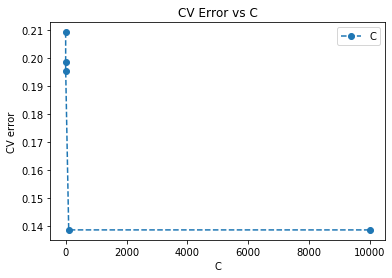

In [21]:
# To choose optimal c, call the linear svc utillity function

optimal_C_bow_grid = svc_grid_linear(std_X_train, y_train)

In [22]:
# instantiate learning model with optimal value
clf = SGDClassifier(loss = "hinge", alpha = optimal_C_bow_grid, class_weight = "balanced")
# fitting the model
clf.fit(std_X_train, y_train)
# linear svc with sigmoid calibration
calib = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
calib.fit(std_X_train, y_train)
# predict the response
pred = clf.predict(std_x_test)
# Predict probabilistic response
pred_prob = calib.predict_proba(std_x_test)[:,1]

In [23]:
# calibrated train accuracy on train data
train_acc_bow_grid = calib.score(std_X_train, y_train)
print("Train accuracy:",train_acc_bow_grid)

Train accuracy: 0.9571428571428572


In [24]:
# roc_auc_score on test data
test_acc_bow_grid = roc_auc_score(y_test, pred_prob) * 100
print("\n Test accuracy", test_acc_bow_grid)


 Test accuracy 88.260336118082


In [25]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[  85,  237],
       [  39, 2639]], dtype=int64)

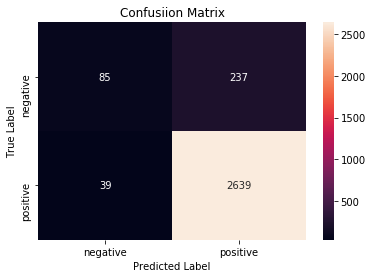

In [26]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [27]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.69      0.26      0.38       322
           1       0.92      0.99      0.95      2678

    accuracy                           0.91      3000
   macro avg       0.80      0.62      0.67      3000
weighted avg       0.89      0.91      0.89      3000



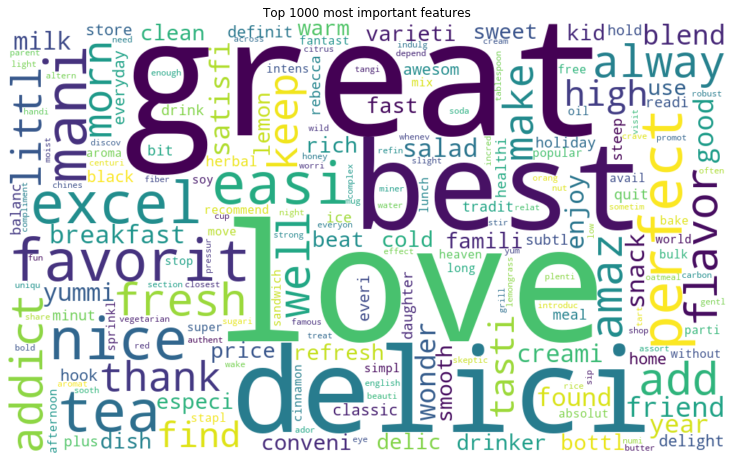

In [28]:
# Wordcloud of top 100 most important features obtained by applying linear svc
from wordcloud import WordCloud, STOPWORDS
# Get feature names 
# After training the model get word coefficient of each features
# Store feature names corresponding with weights or coefficient in a pandas DataFrame
features = bow.get_feature_names()
coef = clf.coef_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef.flatten()}, index = None)
# Sort coefficient in decending order and take top 100 weight
df = coef_df.sort_values("coeficient", ascending = False)[:1000]
# store each word which has high weight in a cloud variable
cloud = " ".join(word for word in df.word)
# Remove duplicate words
stopwords = set(STOPWORDS) 
# call built-in method WordCloud for creating an object for drawing a word cloud 
# because we want to generate a wordcloud of top 100 features
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 1000 most important features")
plt.tight_layout(pad = 0) 
  
plt.show()

**Observations**<br>
1. We tuned hyperparameter using cross-validation where Optimal value of alpha(c) = 1, we get the good train accuracy and roc_auc score as well.
2. Applied linear svc using SGDClassifier on bag-of-words featurization and it generalize well on unseen data.
3. We have also used sigmoid calibration because when a classifier predict probability, it needs to be rescale.
4. Plotted top 1000 most important features in a word cloud, where we found that the "great" and "love" is the most important feature.

# RBF SVC

In [29]:
# Tsking only 10k datapoints because of memory constraints
data = cleaned_data.iloc[:10000,:]
# Store features and class-label in x and y respectevely
X = data["CleanedText"]
y = data["Score"]
# Splitting data into train and test 
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, y_train.shape, x_test.shape, y_test.shape)
# Apply Bow to get feature vector
bow = CountVectorizer(min_df = 10, max_features = 500)
X_train = bow.fit_transform(X_train)
x_test = bow.transform(x_test)
# Standardization
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)
std_x_test = scaler.fit_transform(x_test)

(7000,) (7000,) (3000,) (3000,)


In [30]:
# dimension of train and test data
print("Dimension of train and test data", std_X_train.shape ,std_x_test.shape)
n_train = std_X_train
n_test = std_x_test

Dimension of train and test data (7000, 500) (3000, 500)



**********GridSearchCV**********


Optimal C: 1

Optimal Gamma: 0.0001

Best kernel: rbf

Best Score: 0.8395054313155829


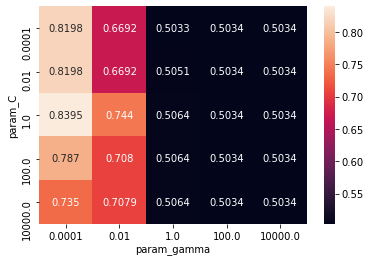

In [31]:
# To choose c and gamma, call the rbf utility function
optimal_C_bow_grid_rbf, optimal_gamma_bow_grid_rbf = svc_grid_rbf(std_X_train, y_train)

In [32]:
# instantiate learning model with optimal value
clf = SVC( kernel = "rbf", class_weight = "balanced", probability = True)
# fitting the model
clf.fit(std_X_train, y_train)
# rbf svc with sigmoid calibration
calib = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
calib.fit(std_X_train, y_train)
# predict the response
pred = calib.predict(std_x_test)
# Predict probabilistic response
pred_prob = calib.predict_proba(std_x_test)[:,1]

In [33]:
# Train accuracy
train_acc_bow_rbf = calib.score(std_X_train, y_train)
print("Train accuracy:", train_acc_bow_rbf)

Train accuracy: 0.9721428571428572


In [34]:
# auc_roc score
test_acc_bow_rbf = roc_auc_score(y_test, pred_prob) * 100
test_acc_bow_rbf

86.34433316788741

In [35]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[  90,  232],
       [  52, 2626]], dtype=int64)

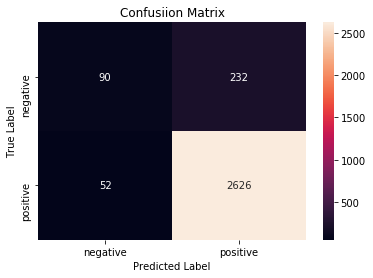

In [36]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [37]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.63      0.28      0.39       322
    positive       0.92      0.98      0.95      2678

    accuracy                           0.91      3000
   macro avg       0.78      0.63      0.67      3000
weighted avg       0.89      0.91      0.89      3000



**Observations**</br>
1. We took only 25k datapoints and vectorize using bow and applied rbf svc.
2. By doing hyperparameter tuning, we get c and gamma value is 1 and 0.0001 respectively. Model Generalize good on test data. 

# Tf-Idf

# Linear SVC

In [38]:
# 100k data which will use to train model after vectorization
X = final_100k["CleanedText"]
print("shape of X:", X.shape)

shape of X: (10000,)


In [39]:
# class label
y = final_100k["Score"]
print("shape of y:", y.shape)

shape of y: (10000,)


In [40]:
# split data into train and test where 70% data used to train model and 30% for test
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, y_train.shape, x_test.shape, y_test.shape)

(7000,) (7000,) (3000,) (3000,)


In [41]:
# Train vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)
X_train

<7000x13637 sparse matrix of type '<class 'numpy.float64'>'
	with 226839 stored elements in Compressed Sparse Row format>

In [42]:
# Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)

In [43]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_test.shape

(3000, 13637)

In [44]:
# Standardization
scaler = StandardScaler(with_mean = False)
std_x_test = scaler.fit_transform(x_test)


**********GridSearchCV**********


Optimal C: 100

Best Score: 0.8591934499865909


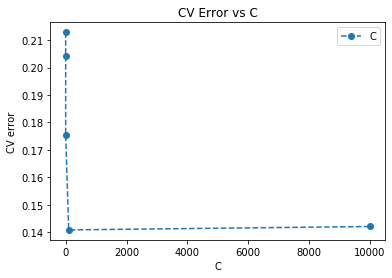

In [45]:
# To choose best C, call the linear svc utility function 
optimal_C_tfidf_grid  = svc_grid_linear(std_X_train, y_train)


In [46]:
# instantiate learning model
clf = SGDClassifier(loss = "hinge", alpha = optimal_C_tfidf_grid, class_weight = "balanced")
# fitting the model
clf.fit(std_X_train, y_train)
# linear svc with sigmoid calibration
calib = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
calib.fit(std_X_train, y_train)
# predict the response
pred = calib.predict(std_x_test)
# Predict probabilistic response
pred_prob = calib.predict_proba(std_x_test)[:,1]

In [47]:
# Train accuracy
train_acc_tfidf_grid = calib.score(std_X_train, y_train)
print("Train accuracy :", (train_acc_tfidf_grid))

Train accuracy : 0.9737142857142858


In [48]:
# roc_auc score
test_acc_tfidf_grid = roc_auc_score(y_test, pred_prob) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_C_tfidf_grid, test_acc_tfidf_grid))


The accuracy of the logistic regression for c = 100.000000 is 89.16%


In [49]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 114,  208],
       [  49, 2629]], dtype=int64)

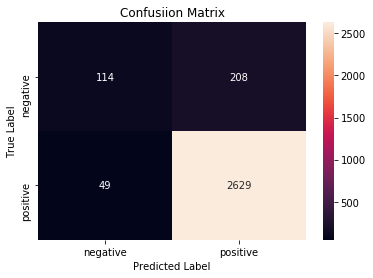

In [50]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [51]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.70      0.35      0.47       322
           1       0.93      0.98      0.95      2678

    accuracy                           0.91      3000
   macro avg       0.81      0.67      0.71      3000
weighted avg       0.90      0.91      0.90      3000



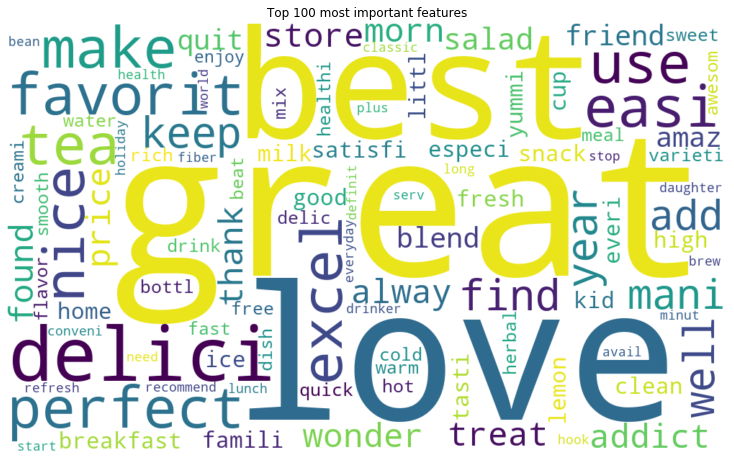

In [52]:
from wordcloud import WordCloud, STOPWORDS

features = tf_idf_vect.get_feature_names()
coef = clf.coef_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef.flatten()}, index = None)
#print(coef_df)
#print(coef)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 100 most important features")
plt.tight_layout(pad = 0)  
plt.show() 

**Observations** <br>
1. We observe that when c value is 1, then the train score is slightly higher than the test score(roc_auc score). There might be change of overfitting.
2. From word cloud, We can also see that when we vectorize text using tfidf, the most important features is almost same as that we get using bow. 

# RBF SVC

In [53]:
# Tsking only 25k datapoints because of memory constraints 
data = cleaned_data.iloc[:10000,:]
X = data["CleanedText"]
y = data["Score"]
#print(X.shape, y.shape)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, y_train.shape, x_test.shape, y_test.shape)
tfidf = TfidfVectorizer(min_df = 10, max_features = 500)
X_train = tfidf.fit_transform(X_train)
x_test = tfidf.transform(x_test)
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)
std_x_test = scaler.fit_transform(x_test)

(7000,) (7000,) (3000,) (3000,)


In [54]:
# Shape of train and test data
print("Dimension of train and test data", std_X_train.shape ,std_x_test.shape)
n_train = std_X_train
n_test = std_x_test

Dimension of train and test data (7000, 500) (3000, 500)



**********GridSearchCV**********


Optimal C: 1

Optimal Gamma: 0.0001

Best kernel: rbf

Best Score: 0.8281007068957568


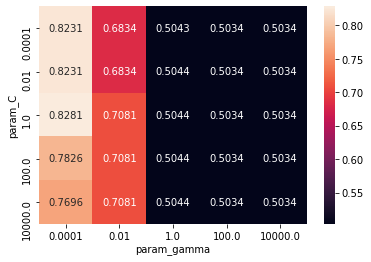

In [55]:
# To choose optimal C and gamma, call the rbf utility function 
optimal_C_tfidf_grid_rbf, optimal_gamma_tfidf_grid_rbf = svc_grid_rbf(std_X_train, y_train)

In [56]:
# instantiate learning model lambda = optimal_lambda
clf = SVC(C = optimal_C_tfidf_grid_rbf, gamma = optimal_gamma_tfidf_grid_rbf, kernel = "rbf", class_weight = "balanced")
# fitting the model
clf.fit(std_X_train, y_train)
# rbf svc with sigmoid calibration
calib = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
calib.fit(std_X_train, y_train)
# predict the response
pred = calib.predict(std_x_test)
# Predict probabilistic response
pred_prob = calib.predict_proba(std_x_test)[:,1]

In [57]:
# Train accuracy
train_acc_tfidf_grid_rbf = calib.score(std_X_train, y_train)
print("Training accuracy:", train_acc_tfidf_grid_rbf)

Training accuracy: 0.9187142857142857


In [58]:
# roc_auc score
test_acc_tfidf_grid_rbf = roc_auc_score(y_test, pred_prob) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' %(optimal_C_tfidf_grid_rbf, test_acc_tfidf_grid_rbf))


The accuracy of the logistic regression for c = 1.000000 is 86.59%


In [59]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 108,  214],
       [  73, 2605]], dtype=int64)

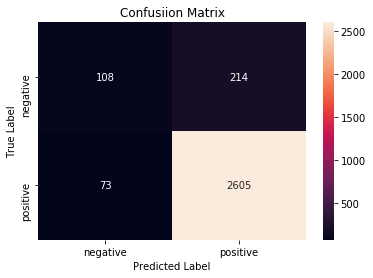

In [60]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [61]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.60      0.34      0.43       322
    positive       0.92      0.97      0.95      2678

    accuracy                           0.90      3000
   macro avg       0.76      0.65      0.69      3000
weighted avg       0.89      0.90      0.89      3000



# Word2vec

In [62]:
# data
X = final_100k["Text"]
X.shape

(10000,)

In [63]:
# Target/class-label
y = final_100k["Score"]
y.shape

(10000,)

In [64]:
# Split data into train and test
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [65]:
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [66]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [67]:
# train word2vec model
w2v_model_train = gensim.models.Word2Vec(list_of_sent, min_count=5, size=50, workers=4)

In [68]:
# Get most similar word of "like"
# By checking this we can be ensure that, our training is good 
w2v_model_train.wv.most_similar('like')

[('think', 0.7867692708969116),
 ('prefer', 0.7560641765594482),
 ('real', 0.7509462833404541),
 ('bitter', 0.720164954662323),
 ('without', 0.7057005763053894),
 ('lover', 0.6833714842796326),
 ('dislike', 0.6819490194320679),
 ('warn', 0.6818321943283081),
 ('enjoy', 0.6801440119743347),
 ('amazing', 0.6781917810440063)]

In [69]:
# To get vocabulary 
w2v_train = w2v_model_train[w2v_model_train.wv.vocab]

In [70]:
# Shape of trained word2vec
w2v_train.shape

(5793, 50)

In [71]:
# Train your own Word2Vec model using your own test text corpus
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [72]:
# Train word2vec with your own corpus
w2v_model_test = gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

In [73]:
w2v_model_test.wv.most_similar('like')

[('too', 0.956222414970398),
 ('want', 0.952271580696106),
 ('do', 0.9495469927787781),
 ('not', 0.9433274865150452),
 ('but', 0.9295401573181152),
 ('really', 0.9286036491394043),
 ('add', 0.9269919395446777),
 ('need', 0.92523592710495),
 ('wont', 0.9251105189323425),
 ('much', 0.9244686961174011)]

In [74]:
w2v_test = w2v_model_test[w2v_model_test.wv.vocab]

In [75]:
w2v_test.shape

(2759, 50)

# Average word2vec

# Linear SVC

In [91]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

7000
50


In [92]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = [] # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

3000
50


In [93]:
# Train data
X_train = sent_vectors

In [94]:
# Standardization of train data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)

In [97]:
# Test data
x_test = sent_vectors_test

In [98]:
# Standardization of test data
scaler = StandardScaler(with_mean = False)
std_x_test = scaler.fit_transform(x_test)


**********GridSearchCV**********


Optimal C: 0.01

Best Score: 0.824565883065624


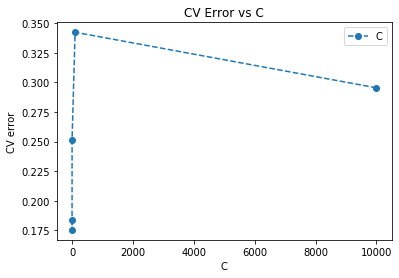

In [99]:
# To choose optimal C 
optimal_C_avgw2v_grid = svc_grid_linear(std_X_train, y_train)

In [100]:
# instantiate learning model lambda = optimal_lambda
clf = SGDClassifier(loss = "hinge", alpha = optimal_C_avgw2v_grid, class_weight = "balanced", shuffle = False)
# fitting the model
clf.fit(std_X_train, y_train)
# linear svc with sigmoid calibration
calib = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
calib.fit(std_X_train, y_train)
# predict the response
pred = calib.predict(std_x_test)
# Predict probabilistic response
pred_prob = calib.predict_proba(std_x_test)[:,1]

In [101]:
# Train acuracy
train_acc_avgw2v_grid = calib.score(std_X_train, y_train)
print("Train accuracy:", train_acc_avgw2v_grid)

Train accuracy: 0.8895714285714286


In [102]:
# roc_auc score
test_acc_avgw2v_grid = roc_auc_score(y_test, pred_prob) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_C_avgw2v_grid, test_acc_avgw2v_grid))


The accuracy of the logistic regression for c = 0.010000 is 66.74%


In [103]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[   0,  322],
       [   0, 2678]], dtype=int64)

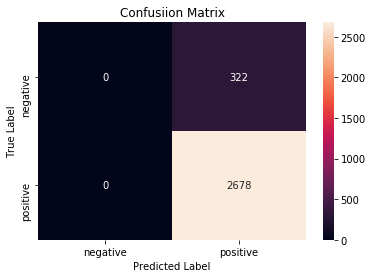

In [104]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [105]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       322
           1       0.89      1.00      0.94      2678

    accuracy                           0.89      3000
   macro avg       0.45      0.50      0.47      3000
weighted avg       0.80      0.89      0.84      3000



# RBF SVC


**********GridSearchCV**********


Optimal C: 100

Optimal Gamma: 0.0001

Best kernel: rbf

Best Score: 0.8275166381589236


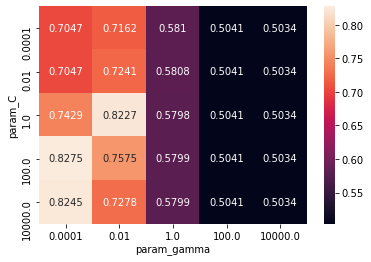

In [106]:
# To choose optimal C and gamma, call the rbf svc utility function 
optimal_C_avgw2v_grid_rbf, optimal_gamma_avgw2v_grid_rbf = svc_grid_rbf(std_X_train, y_train)

In [107]:
# instantiate learning model lambda = optimal_lambda
#lr_model =  LogisticRegression(penalty = 'l1', C = optimal_lambda_bow)
clf = SVC(C = optimal_C_avgw2v_grid_rbf, gamma = optimal_gamma_avgw2v_grid_rbf, kernel = "rbf", class_weight = "balanced", probability = True)
# fitting the model
clf.fit(std_X_train, y_train)
# rbf svc with sigmoid calibration
calib = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
calib.fit(std_X_train, y_train)
# predict the response
pred = calib.predict(std_x_test)
# Predict probabilistic response
pred_prob = calib.predict_proba(std_x_test)[:,1]

In [108]:
# Accuracy on train data
train_acc_avgw2v_grid_rbf = calib.score(std_X_train, y_train)
print("Train accuracy", train_acc_avgw2v_grid_rbf)

Train accuracy 0.8911428571428571


In [109]:
# roc_auc score
test_acc_avgw2v_grid_rbf = roc_auc_score(y_test, pred_prob) * 100
print('\nTest accuracy is %.2f%%' % (test_acc_avgw2v_grid_rbf))


Test accuracy is 65.46%


In [110]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[   0,  322],
       [   0, 2678]], dtype=int64)

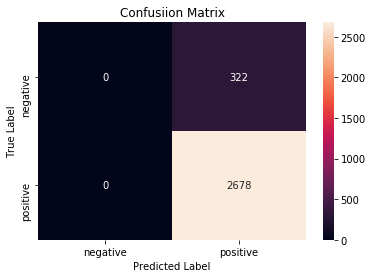

In [111]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [112]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       322
           1       0.89      1.00      0.94      2678

    accuracy                           0.89      3000
   macro avg       0.45      0.50      0.47      3000
weighted avg       0.80      0.89      0.84      3000



# TFIDF Word2Vec

# Linear SVC

In [113]:
# TF-IDF weighted Word2Vec train dataset
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  

In [114]:
# tf idf  weigthed word2vec test dataset

tfidf_feat = tf_idf_vect.get_feature_names() #tfidf words / col name

#final tf idf is the sparse matrix with row = sentence col=word and cell val = tfidf

tfidf_sent_vectors_test = [] #the tfdif w2v row = sentence review is stored in the list

row = 0

for sent in  list_of_sent_test: #for each review or sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            # obtain the tf idf of a word in sentence / review
            tfidf = final_tf_idf[row , tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [115]:
# Convert non to zero and large finite number to finite number for train data
# because we can not built model with nan or infine number
X_train = np.nan_to_num(X_train)
X_train

array([[ 0.3230189 ,  0.05741069, -0.46547732, ..., -0.75243798,
         0.01658249, -0.07412182],
       [ 0.49705516,  0.1862864 , -0.54627095, ..., -0.94418906,
        -0.08764199, -0.26255932],
       [ 0.16666281, -0.40654908, -0.61918642, ..., -0.72072471,
         0.27236038,  0.15594947],
       ...,
       [ 0.35155679, -0.25399439, -0.78393203, ..., -0.98254016,
        -0.12292671, -0.23309207],
       [-0.03599567,  0.07659743, -1.29563939, ..., -0.49555087,
         0.00970767, -0.03750731],
       [ 0.14377737, -0.45983459, -0.61585596, ..., -0.16885735,
        -0.59809354, -0.07655221]])

In [116]:
# Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)

In [117]:
# Convert non to zero and large finite number to finite number for test data
x_test = np.nan_to_num(x_test)
x_test

array([[ 0.03523432,  0.00641315, -0.69579566, ..., -0.68672873,
         0.24446587,  0.17263636],
       [ 0.04249931, -0.00905916, -0.74748218, ..., -0.69269044,
         0.25452761,  0.18097712],
       [ 0.06891749, -0.03797562, -0.78582265, ..., -0.58574154,
         0.32119418,  0.18627068],
       ...,
       [ 0.12472159,  0.05092061, -0.73841609, ..., -0.71953846,
         0.22430323,  0.21200655],
       [-0.06330151, -0.22750028, -0.97139093, ..., -0.57394508,
         0.33817998,  0.17824753],
       [ 0.05165772, -0.02067043, -0.6910301 , ..., -0.55070716,
         0.30016073,  0.14458343]])

In [118]:
# Standardization on test data
scaler = StandardScaler(with_mean = False)
std_x_test = scaler.fit_transform(x_test)


**********GridSearchCV**********


Optimal C: 0.01

Best Score: 0.8238235508086845


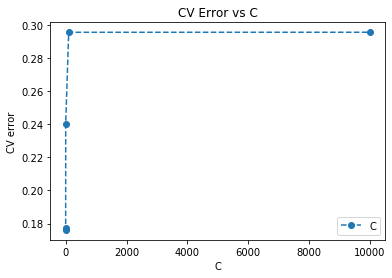

In [119]:
# To choose best C
optimal_C_tfidfw2v_grid = svc_grid_linear(std_X_train, y_train)

In [120]:
# instantiate learning model
clf = SGDClassifier(loss = "hinge", alpha = optimal_C_tfidfw2v_grid, class_weight = "balanced")
# fitting the model
clf.fit(std_X_train, y_train)
calib = CalibratedClassifierCV(clf, cv = "prefit")
calib.fit(std_X_train, y_train)
# predict the response
pred = calib.predict(std_x_test)
# Predict probabilistic response
pred_prob = calib.predict_proba(std_x_test)[:,1]

In [121]:
# Accuracy on train data
train_acc_tfidfw2v_grid = calib.score(std_X_train, y_train)
print("Train accuracy", train_acc_tfidfw2v_grid)

Train accuracy 0.889


In [122]:
# roc_auc score
test_acc_tfidfw2v_grid = roc_auc_score(y_test, pred_prob) * 100
print('\nThe accuracy for c = %0.3f is %f%%' % (optimal_C_tfidfw2v_grid, test_acc_tfidfw2v_grid))


The accuracy for c = 0.010 is 66.755690%


In [123]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[   0,  322],
       [   0, 2678]], dtype=int64)

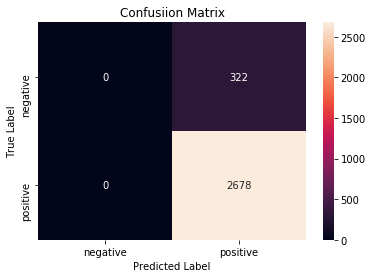

In [124]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [125]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       322
           1       0.89      1.00      0.94      2678

    accuracy                           0.89      3000
   macro avg       0.45      0.50      0.47      3000
weighted avg       0.80      0.89      0.84      3000



# RBF SVC


**********GridSearchCV**********


Optimal C: 100

Optimal Gamma: 0.0001

Best kernel: rbf

Best Score: 0.8275166381589236


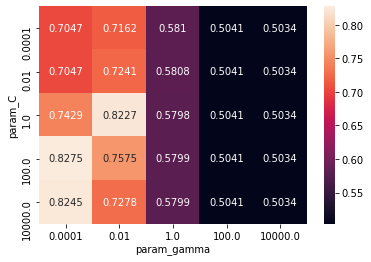

In [126]:
# Find optimal C and gamma for rbf svc 
optimal_C_tfidfw2v_grid_rbf, optimal_gamma_tfidfw2v_grid_rbf = svc_grid_rbf(std_X_train, y_train)

In [127]:
# instantiate learning model lambda = optimal_lambda
#lr_model =  LogisticRegression(penalty = 'l1', C = optimal_lambda_bow)
clf = SVC(C = optimal_C_tfidfw2v_grid_rbf, gamma = optimal_gamma_tfidfw2v_grid_rbf, kernel = "rbf", class_weight = "balanced", probability = True)
# fitting the model
clf.fit(std_X_train, y_train)
calib = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
calib.fit(std_X_train, y_train)
# predict the response
pred = calib.predict(std_x_test)
# Predict probabilistic response
pred_prob = calib.predict_proba(std_x_test)[:,1]

In [128]:
# Accuracy on train data
train_acc_tfidfw2v_grid_rbf = calib.score(std_X_train, y_train)
print("Train accuracy", train_acc_tfidfw2v_grid_rbf)

Train accuracy 0.8911428571428571


In [129]:
# roc_auc score
test_acc_tfidfw2v_grid_rbf = roc_auc_score(y_test, pred_prob) * 100
print('\nThe test accuracy is %.2f%%' % (test_acc_tfidfw2v_grid_rbf))


The test accuracy is 65.46%


In [130]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[   0,  322],
       [   0, 2678]], dtype=int64)

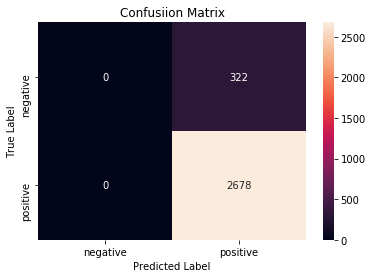

In [131]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [132]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       322
           1       0.89      1.00      0.94      2678

    accuracy                           0.89      3000
   macro avg       0.45      0.50      0.47      3000
weighted avg       0.80      0.89      0.84      3000



In [136]:
# model performence table using grid search

models = pd.DataFrame({'Model': ['Linear SVC with Bow', "Linear SVC with TFIDF", "Linear SVC with avgw2v", "Linear SVC with TFIDFW2V"],
                       'Hyper Parameter(C)': [optimal_C_bow_grid, optimal_C_tfidf_grid, optimal_C_avgw2v_grid, optimal_C_tfidfw2v_grid ],
                       'Train Error': [1-train_acc_bow_grid, 1-train_acc_tfidf_grid, 1-train_acc_avgw2v_grid, 1-train_acc_tfidfw2v_grid], 
                       'Test Error': [100-test_acc_bow_grid, 100-test_acc_tfidf_grid, 100-test_acc_avgw2v_grid, 100-test_acc_tfidfw2v_grid], 'Roc_Auc_Score': [test_acc_bow_grid, test_acc_tfidf_grid, test_acc_avgw2v_grid, test_acc_tfidfw2v_grid]}, columns = ["Model", "Hyper Parameter(C)", "Train Error", "Test Error", "Roc_Auc_Score"])
models.sort_values(by='Roc_Auc_Score', ascending=False)

,Model,Hyper Parameter(C),Train Error,Test Error,Roc_Auc_Score
1,Linear SVC with TFIDF,100.00,0.026286,10.841037,89.158963
0,Linear SVC with Bow,10000.00,0.042857,11.739664,88.260336
3,Linear SVC with TFIDFW2V,0.01,0.111000,33.244310,66.755690
2,Linear SVC with avgw2v,0.01,0.110429,33.263908,66.736092


In [137]:
# model performence table using random search
models = pd.DataFrame({'Model': ['RBF SVC with Bow', "RBF SVC with TFIDF", "RBF SVC with avgw2v", "RBF SVC  with TFIDFW2V"],
                       'Hyper Parameter(C)': [optimal_C_bow_grid_rbf, optimal_C_tfidf_grid_rbf, optimal_C_avgw2v_grid_rbf, optimal_C_tfidfw2v_grid_rbf],
                       "Hyper Parameter(gamma)": [optimal_gamma_bow_grid_rbf, optimal_gamma_tfidf_grid_rbf, optimal_gamma_avgw2v_grid_rbf, optimal_gamma_tfidfw2v_grid_rbf],
                       'Train Error': [1-train_acc_bow_rbf, 1-train_acc_tfidf_grid_rbf, 1-train_acc_avgw2v_grid_rbf, 1-train_acc_tfidfw2v_grid_rbf],
                       'Test Error': [100-test_acc_bow_rbf, 100-test_acc_tfidf_grid_rbf, 100-test_acc_avgw2v_grid_rbf, 100-test_acc_tfidfw2v_grid_rbf], 'Roc_Auc_Score': [test_acc_bow_rbf, test_acc_tfidf_grid_rbf, test_acc_avgw2v_grid_rbf, test_acc_tfidfw2v_grid_rbf]}, columns = ["Model", "Hyper Parameter(C)", "Hyper Parameter(gamma)", "Train Error", "Test Error", "Roc_Auc_Score"])
models.sort_values(by = 'Roc_Auc_Score' , ascending = False)

,Model,Hyper Parameter(C),Hyper Parameter(gamma),Train Error,Test Error,Roc_Auc_Score
1,RBF SVC with TFIDF,1,0.0001,0.081286,13.409353,86.590647
0,RBF SVC with Bow,1,0.0001,0.027857,13.655667,86.344333
2,RBF SVC with avgw2v,100,0.0001,0.108857,34.538963,65.461037
3,RBF SVC with TFIDFW2V,100,0.0001,0.108857,34.538963,65.461037
